In [3]:
import os
import re
import pandas as pd
import numpy as np
import json
import collections
import matplotlib.pyplot as plt

Files and data

In [6]:
data_dir = os.path.join(os.getenv("DATA_DIR"), "narrative_understanding/chatter/attr_verify")
attributes_file = os.path.join(os.getenv("DATA_DIR"), "narrative_understanding/chatter/attributes.txt")
segment_file = os.path.join(data_dir, "segment_descriptions.csv")
scene_file = os.path.join(data_dir, "scene_descriptions.csv")
flan_files = filter(lambda f: re.match(r"flan_t5_(\d+)_of_(\d+)\.csv", f), 
                    os.listdir(os.path.join(data_dir, "flan_t5_v1")))

segment_df = pd.read_csv(segment_file, index_col=None)
print(f"segment descriptions {segment_df.shape}")
display(segment_df.head(5))
print()

scene_df = pd.read_csv(scene_file, index_col=None)
print(f"scene descriptions {scene_df.shape}")
display(scene_df.head(5))
print()

flan_dfs = [pd.read_csv(os.path.join(data_dir, "flan_t5_v1", f), index_col=None) for f in flan_files]
flan_df = pd.concat(flan_dfs)
print(f"flan-t5 verifications {flan_df.shape}")
display(flan_df.head(5))

segment descriptions (710294, 4)


,imdb_id,segment_id,segment_text,character
0,120660,2,HAMERSLEY MAKES VERBAL NOTES concerning the Re...,HAMERSLEY
1,120660,2,HAMERSLEY MAKES VERBAL NOTES concerning the Re...,REYNOLDS
2,120660,3,HAMERSLEY tries again but can't get a dial ton...,HAMERSLEY
3,120660,4,"HAMERSLEY's eyes widen. He stomps the brakes, ...",HAMERSLEY
4,120660,5,"ROBERT DEAN, a likable young lawyer, sits behi...",ROBERT DEAN



scene descriptions (302259, 4)


,imdb_id,scene_id,scene_text,character
0,2053463,0,EXT. OTISVILLE CORRECTIONAL FACILITY - MORNING...,EMILY
1,2053463,0,EXT. OTISVILLE CORRECTIONAL FACILITY - MORNING...,MARTHA
2,2053463,0,EXT. OTISVILLE CORRECTIONAL FACILITY - MORNING...,MARTIN
3,2053463,0,EXT. OTISVILLE CORRECTIONAL FACILITY - MORNING...,EM
4,2053463,1,INT. NYC PARKING GARAGE - A LITTLE LATER\nEmil...,EMILY



flan-t5 verifications (10956669, 5)


,id,attr,answer_text,answer_token_id,answer_prob
0,277645,goal,no,150,0.355225
1,277646,goal,no,150,0.416992
2,277647,goal,no,150,0.684082
3,277665,goal,no,150,0.626465
4,277666,goal,no,150,0.681641


FLAN T5 answers

In [7]:
print(f"FLAN T5 answer texts = {dict(collections.Counter(flan_df.answer_text))}")

FLAN T5 answer texts = {'no': 9870265, 'yes': 1086378, 'con': 13, '[': 4, nan: 8, 'm': 1}


answer='yes' prob => min = 0.27, max = 0.99, mean = 0.63, std = 0.151
answer='no' prob => min = 0.25, max = 0.99, mean = 0.78, std = 0.142


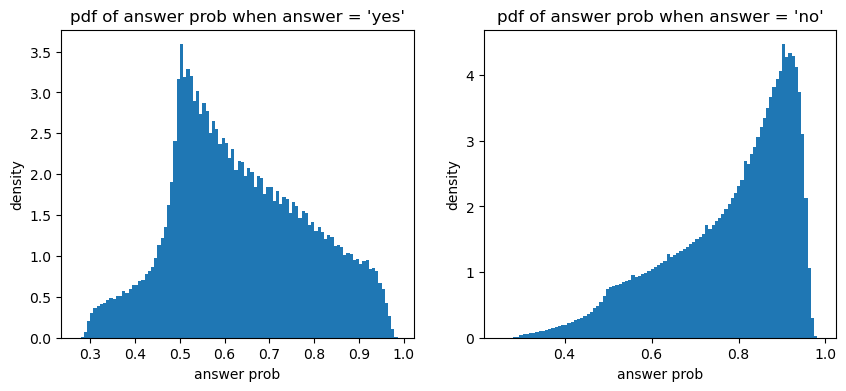

In [8]:
prob_yes = flan_df[flan_df.answer_text == "yes"].answer_prob.values
prob_no = flan_df[flan_df.answer_text == "no"].answer_prob.values
print(f"answer='yes' prob => min = {np.min(prob_yes):.2f}, max = {np.max(prob_yes):.2f}, "
      f"mean = {np.mean(prob_yes):.2f}, std = {np.std(prob_yes):.3f}")
print(f"answer='no' prob => min = {np.min(prob_no):.2f}, max = {np.max(prob_no):.2f}, "
      f"mean = {np.mean(prob_no):.2f}, std = {np.std(prob_no):.3f}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(prob_yes, bins=100, density=True)
plt.xlabel("answer prob")
plt.ylabel("density")
plt.title("pdf of answer prob when answer = 'yes'")
plt.subplot(1, 2, 2)
plt.hist(prob_no, bins=100, density=True)
plt.xlabel("answer prob")
plt.ylabel("density")
plt.title("pdf of answer prob when answer = 'no'")
plt.show()

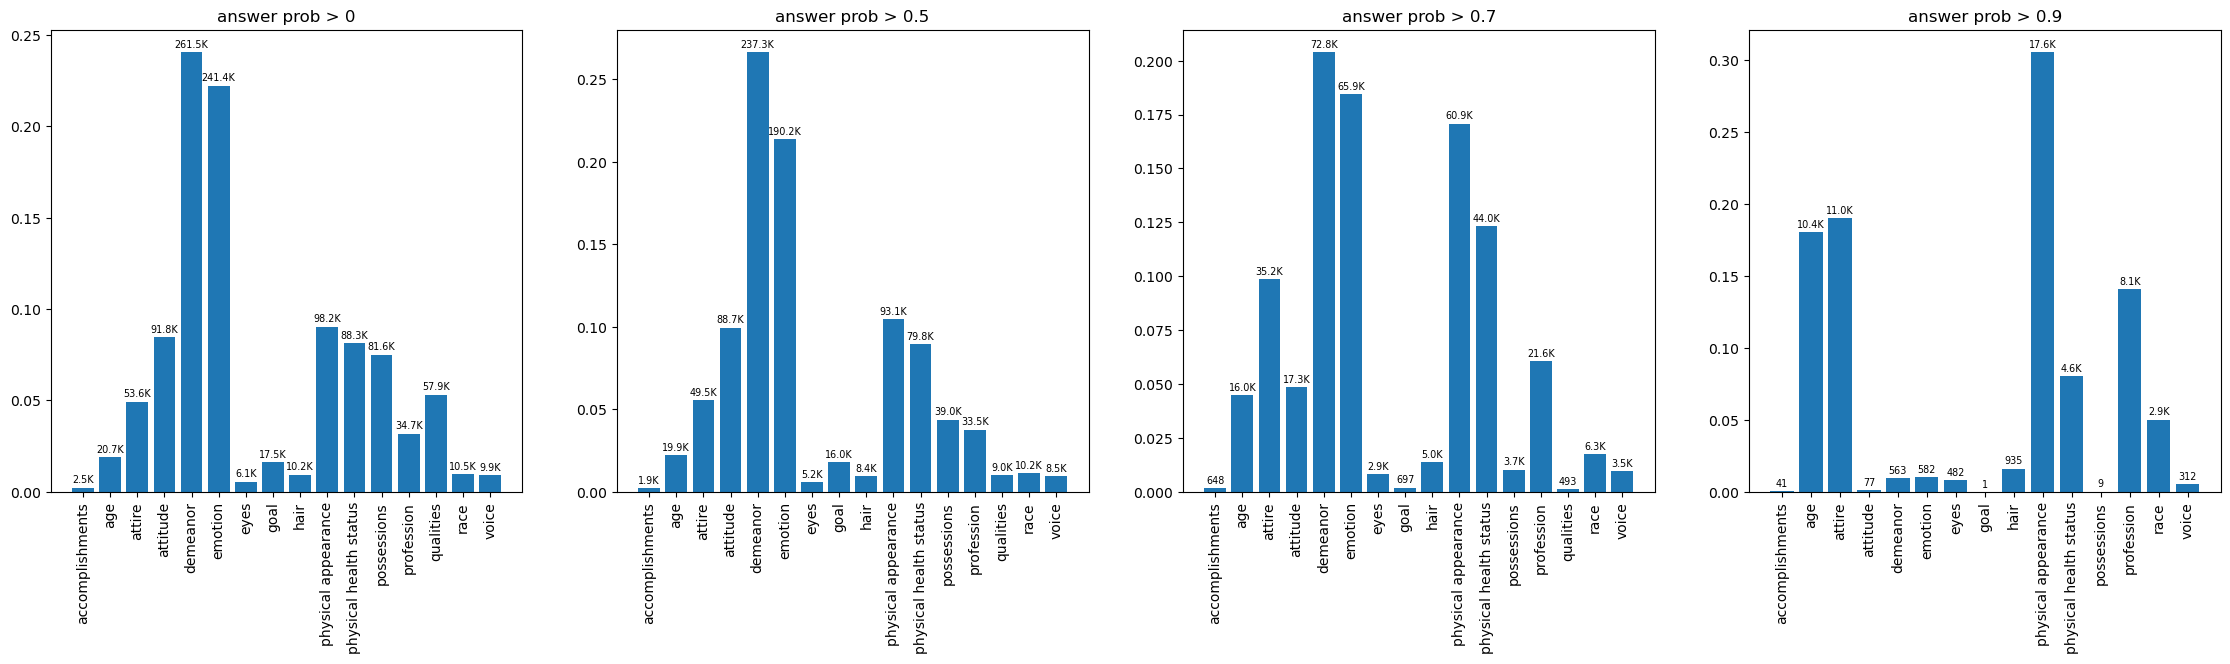

In [9]:
lower_cutoff_probs = [0, 0.5, 0.7, 0.9]

plt.figure(figsize=(28, 6))
for i, prob in enumerate(lower_cutoff_probs):
    mask = (flan_df.answer_prob > prob) & (flan_df.answer_text == "yes")
    x, y = [], []
    for attr, attr_df in flan_df[mask].groupby("attr", sort=True):
        x.append(attr)
        y.append(len(attr_df))
    y_frac = np.array(y)/mask.sum()
    y_label = [f"{count/10**6:.1f}M" if count > 10**6 else f"{count/10**3:.1f}K" if count > 10**3 else count 
               for count in y]
    plt.subplot(1, 4, i + 1)
    bc = plt.bar(x, y_frac)
    plt.bar_label(bc, y_label, padding=2, fontsize="x-small")
    plt.xticks(rotation=90)
    plt.title(f"answer prob > {prob}")
plt.show()

In [11]:
lower_cutoff_prob = 0.7
n_samples_per_attr = 5

header = ["text", "character", "attr", "yes_prob"]
rows = []
for attr, attr_df in flan_df[(flan_df.answer_text == "yes") 
                             & (flan_df.answer_prob > lower_cutoff_prob)].groupby("attr", sort=True):
    for _, attr_row in attr_df.sample(n=min(len(attr_df), n_samples_per_attr)).iterrows():
        ind = attr_row["id"]
        if attr != "goal":
            text, character = segment_df.loc[ind, ["segment_text", "character"]].values
        else:
            text, character = scene_df.loc[ind, ["scene_text", "character"]].values
        prob = attr_row["answer_prob"]
        rows.append([text, character, attr, prob])
sample_df = pd.DataFrame(rows, columns=header)
output_file = os.path.join(data_dir, 
                           f"flan_t5_v1/character_descriptions_flan_answer_prob_yes>{lower_cutoff_prob}.csv")
sample_df.to_csv(output_file, index=False)